# Installation
The code below is installing the pinard and scikeras packages via pip, the package installer for Python. pinard is a package designed to perform preprocessing and modeling of spectral data, and scikeras is a package that allows to use Keras models in scikit-learn. By running these commands, the packages will be installed and can be imported and used in the current notebook or environment

In [1]:
!pip install pinard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Combine predictors using Stacking


## Loading data

The code above is using the pinard package to load and preprocess data from the provided CSV files. The data is loaded into the x and y variables and then split into training and test sets using the train_test_split_idx function. The preprocessing pipeline is then declared with a list of preprocessing steps, each step is a tuple containing a name and an instance of a preprocessing class. The preprocessing steps include : 'id' for identity transformer, 'savgol' for Savitzky-Golay smoothing filter, 'gaussian1' and 'gaussian2' for Gaussian filter with different parameter, 'haar' for Haar wavelet filter, and several steps that are composed of different preprocessing steps using the pipeline class from scikit-learn. These steps will be applied in sequence to the data in the final pipeline.

In [2]:
# Standard loading and preprocessing code

import numpy as np
from sklearn.pipeline import Pipeline

from pinard import utils
from pinard import preprocessing as pp
from pinard.model_selection import train_test_split_idx

# Init basic random
rd_seed = 42
np.random.seed(rd_seed)

xcal_csv = "https://raw.githubusercontent.com/GBeurier/pinard/main/examples/Xcal.csv"
ycal_csv = "https://raw.githubusercontent.com/GBeurier/pinard/main/examples/Ycal.csv"

# Create a set named data
x, y = utils.load_csv(xcal_csv, ycal_csv, x_hdr=0, y_hdr=0, remove_na=True)
train_index, test_index = train_test_split_idx(x, y=y, method="random", test_size=0.25, random_state=rd_seed)
X_train, y_train, X_test, y_test = x[train_index], y[train_index], x[test_index], y[test_index]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



### Declare preprocessing pipeline components
preprocessing = [   ('id', pp.IdentityTransformer()),
                    ('savgol', pp.SavitzkyGolay()),
                    ('gaussian1', pp.Gaussian(order = 1, sigma = 2)),
                    ('gaussian2', pp.Gaussian(order = 2, sigma = 1)),
                    ('haar', pp.Wavelet('haar')),
                    ('savgol*savgol', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.SavitzkyGolay())])),
                    ('gaussian1*savgol', Pipeline([('_g1',pp.Gaussian(order = 1, sigma = 2)),('_sg3',pp.SavitzkyGolay())])),
                    ('gaussian2*savgol', Pipeline([('_g2',pp.Gaussian(order = 1, sigma = 2)),('_sg4',pp.SavitzkyGolay())])),
                    ('haar*savgol', Pipeline([('_haar2',pp.Wavelet('haar')),('_sg5',pp.SavitzkyGolay())]))
                ]



(270, 2151) (270,) (91, 2151) (91,)


## Pipelines creation

This code is setting up a pipeline for a stacking regressor. The pipeline starts with the union_pipeline which is a pipeline that contains the preprocessing steps that were defined earlier and the MinMaxScaler which scales the data between 0 and 1. The FeatureUnion class is used to combine the results of all the preprocessing steps into a single array. The get_estimator function is a helper function that creates a new pipeline by adding a regressor to the union_pipeline. This new pipeline is wrapped with a TransformedTargetRegressor object, which applies the same scaling on both the input and output data. The estimators list contains the different models that will be used in the stacking regressor. Each model is represented by a name and an instance of the TransformedTargetRegressor class. The final estimator is the RidgeCV, a Ridge regression model with built-in cross-validation. The StackingRegressor class is then initialized with the list of estimators and the final estimator. This will train the different models in parallel and then use the RidgeCV model to make the final predictions using the outputs of the other models as input.

In [6]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor

# create a pipeline that applies min-max scaling followed by preprocessing
union_pipeline = make_pipeline(MinMaxScaler(), FeatureUnion(preprocessing))

# this function creates a pipeline that applies the union_pipeline followed by the regressor
def get_estimator(regressor):
    pipeline = make_pipeline(union_pipeline, regressor)
    return TransformedTargetRegressor(regressor = pipeline, transformer = MinMaxScaler())

# create a list of estimators to use in the stacking regressor, each one is a pipeline of the union_pipeline and a regressor
estimators = [
    ("Random Forest", get_estimator( RandomForestRegressor(random_state=rd_seed) ) ),
    ("PLS", get_estimator( PLSRegression(n_components=10) ) ),
    ("PLS_small", get_estimator( PLSRegression(n_components=3) ) ),
    ("XGBoost", get_estimator( XGBRegressor() ) )
]

# create the stacking regressor, using the list of estimators and a final regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

# Prediction and Visualization

The code below is visualizing the results of the different models and the stacked regressor. It uses the cross_validate and cross_val_predict functions from scikit-learn to evaluate the models. The cross_validate function performs cross-validation on the models using the defined scoring metric (in this case R-squared and mean absolute error) and returns the results as a dictionary. The cross_val_predict function is used to generate predictions for all the samples in the dataset using the k-fold cross-validation. The plot_regression_results is a helper function that creates a scatter plot of the predicted vs true targets. The plot shows the true values on the x-axis and the predicted values on the y-axis. A perfect model will have all the points on the y=x line. A line and a scatter plot are plotted, the line y=x represents the perfect predictions. The performance of the models is measured by the R-squared metric and the mean absolute error. The function also displays the elapsed time for training and evaluating the model. At the end, the code is creating a figure with 3 rows and 2 columns of subplots to show the results of the different models, and the stacked regressor. The figure has a title, and it is showing the results using plt.show().

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 10.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 10.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 10.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend

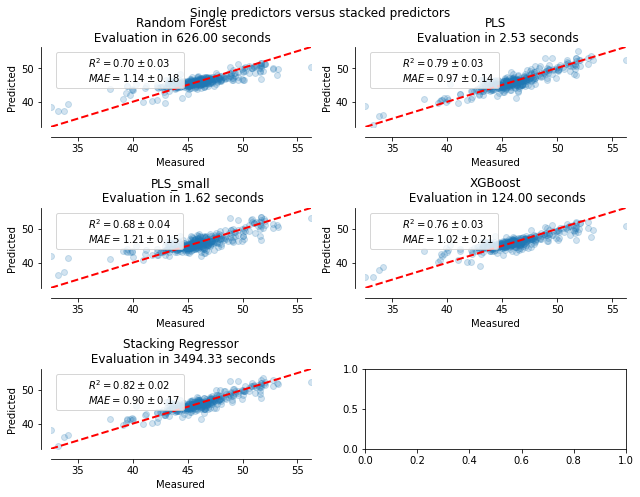

In [7]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict

# function to plot a scatter plot of the predicted vs true targets,
# along with the scores and elapsed time of the model
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    # plot the line y=x for reference
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    # formatting the plot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0)
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(3, 2, figsize=(9, 7))
axs = np.ravel(axs)

# looping through estimators and the stacking regressor
for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
    start_time = time.time()
    # using cross_validate to get scores and elapsed time
    score = cross_validate(est, x, y, cv=4, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=2)
    elapsed_time = time.time() - start_time

    # using cross_val_predict to get predicted values
    y_pred = cross_val_predict(est, x, y, cv=4, n_jobs=2, verbose=1)

    # call the plot_regression_results function
    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

# add subtitle and show the scatter plot
plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()